# Dataset Generation for LLM Prompt Recovery

What we want to do is to create a dataset that will be used for finetuning different NLP models on one precise task. Prompt Recovery. At the end the output will be an evaluation of these different models on this task.

In [1]:
%%capture
%pip install -q -U transformers
%pip install -q -U accelerate
%pip install -q -U bitsandbytes
%pip install -q -U sentence-transformers

In [2]:
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import difflib
from wordcloud import WordCloud
from transformers import AutoTokenizer

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_hf = user_secrets.get_secret("HUGGINGFACE_TOKEN")

In [4]:
!huggingface-cli login --token $secret_hf

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Load some data
For the Kaggle competiton Gemma 7b was used for creating a test dataset, so it could be a valuable option but we need to consider:
- We should not consider those *rewritten_prompts* that already include the original prompt like "Here is your sea shanty:"

In [5]:
gali1eo = pd.read_csv('/kaggle/input/llm-recovery-pair/gemma_v1_7b-it.csv')
gali1eo["original_text"] = gali1eo["document"]
gali1eo["rewritten_text"] = gali1eo["rewritten"]
gali1eo["rewrite_prompt"] = gali1eo["rewritten_prompt"]
gali1eo = gali1eo[['id', 'original_text', 'rewrite_prompt', 'rewritten_text']]
gali1eo.head(5)

id                                      original_text  \
0  35671182  Hayley Murdoch, 29, and Sheila Dixon, 71, both...   
1  35572796  The railway line was closed for a number of ho...   
2  14394831  Presented by Barney Harwood, this Newsround sp...   
3  36316854  They are a 317-unit development in the Athleti...   
4  40738583  VW said it was normal for manufacturers to exc...   

                                      rewrite_prompt  \
0     Turn this into a responsibility to be assumed.   
1    Explain this as if it were a mentor's guidance.   
2  Transform it into a grand opera's dramatic fin...   
3   Transform it into a cooking recipe with a twist.   
4  Write the text as if it were a professional ph...   

                                      rewritten_text  
0  Sure, here is the responsibility to be assumed...  
1  Here is the explanation with a mentor's guidan...  
2  ## The Final Curtain Rises\n\n**Scene:** The e...  
3  **Recipe for Spicy Chicken Wings with a Caribb...  
4  **Photo Shoot Plan - Volkswagen Cartel Allegat...

In [6]:
rewrite_nbroad = pd.read_csv("/kaggle/input/gemma-rewrite-nbroad/nbroad-v2.csv")
rewrite_nbroad.head(5)

id                                      original_text  \
0  lZGdiueMer  `` Well, there are healthier ways to tell me y...   
1  DfTJVFKrUk  Rory ran his shaky fingers through his wife's ...   
2  LmJvKranXK  As I made my way on foot across town to the Po...   
3  PpnqXQAdGH  `` Hello. We come in peace.'' \n \n The first ...   
4  qOeXTfqgAM  `` Karen, what the helllllll izzz...'' says my...   

                                      rewrite_prompt  \
0  Rewrite the story where the writer asks the re...   
1               Rewrite the essay as a dramatic play   
2  Rewrite the story with all the themes and sett...   
3  Rewrite the essay if the advanced aliens didn'...   
4  Rewrite the story as a court room drama starri...   

                                      rewritten_text  
0  Well, there are healthier ways to tell me you ...  
1  ## The Final Curtain\n\n[FADE IN]\n\n**Setting...  
2  As I made my way through the Tatooine desert o...  
3  `` Hello. We come in peace.''\n\nThe first enc...  
4  The courtroom erupted in an uproar as District...

# Data Analysis

Let's do some data analysis of our datasets

In [7]:
def generate_wordcloud(df, column):
    text = " ".join(word for word in df[column].dropna())
    wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)
    return wordcloud

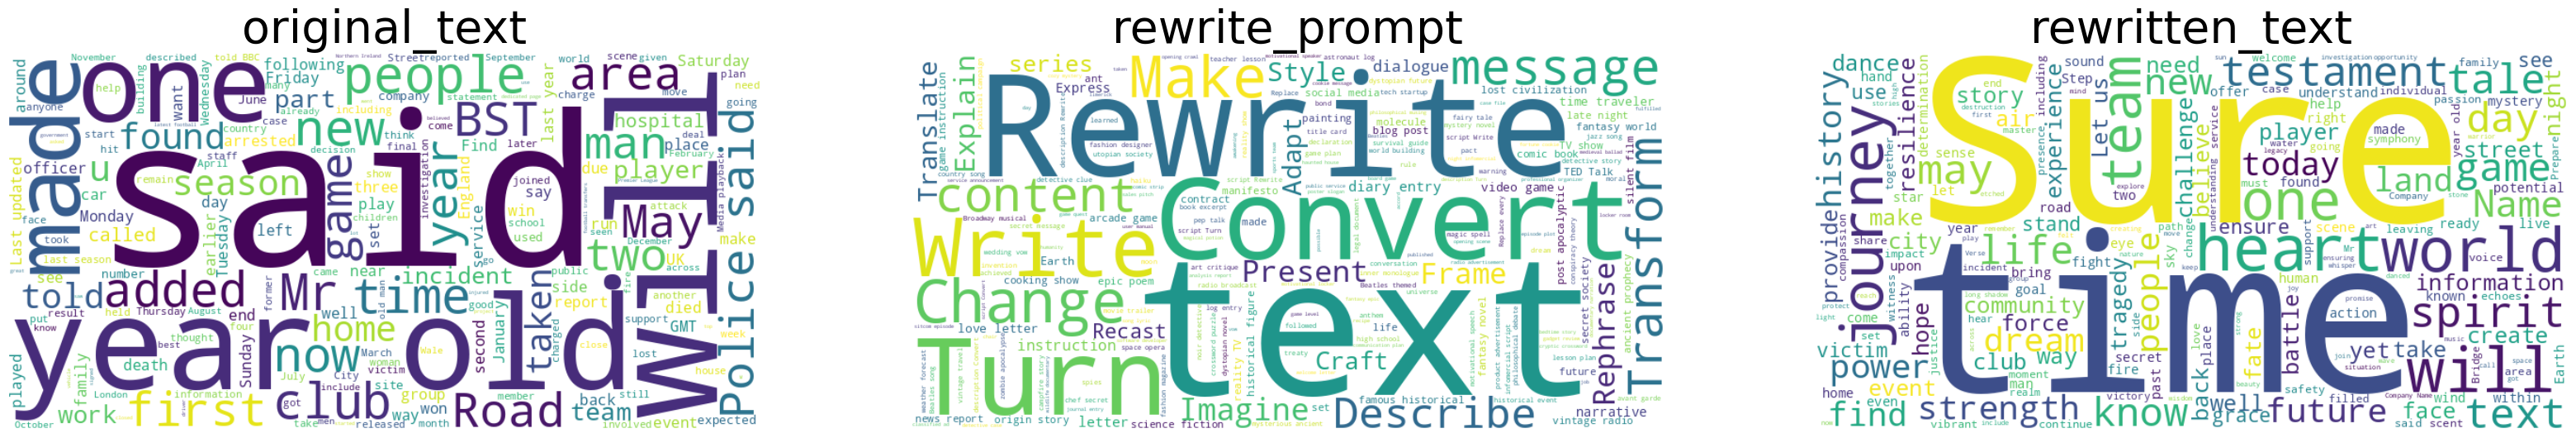

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(40, 20))
columns = ['original_text', 'rewrite_prompt', 'rewritten_text']
for i, column in enumerate(columns):
    wordcloud = generate_wordcloud(gali1eo, column)
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis("off")
    axs[i].set_title(column,fontsize=40)

plt.show()

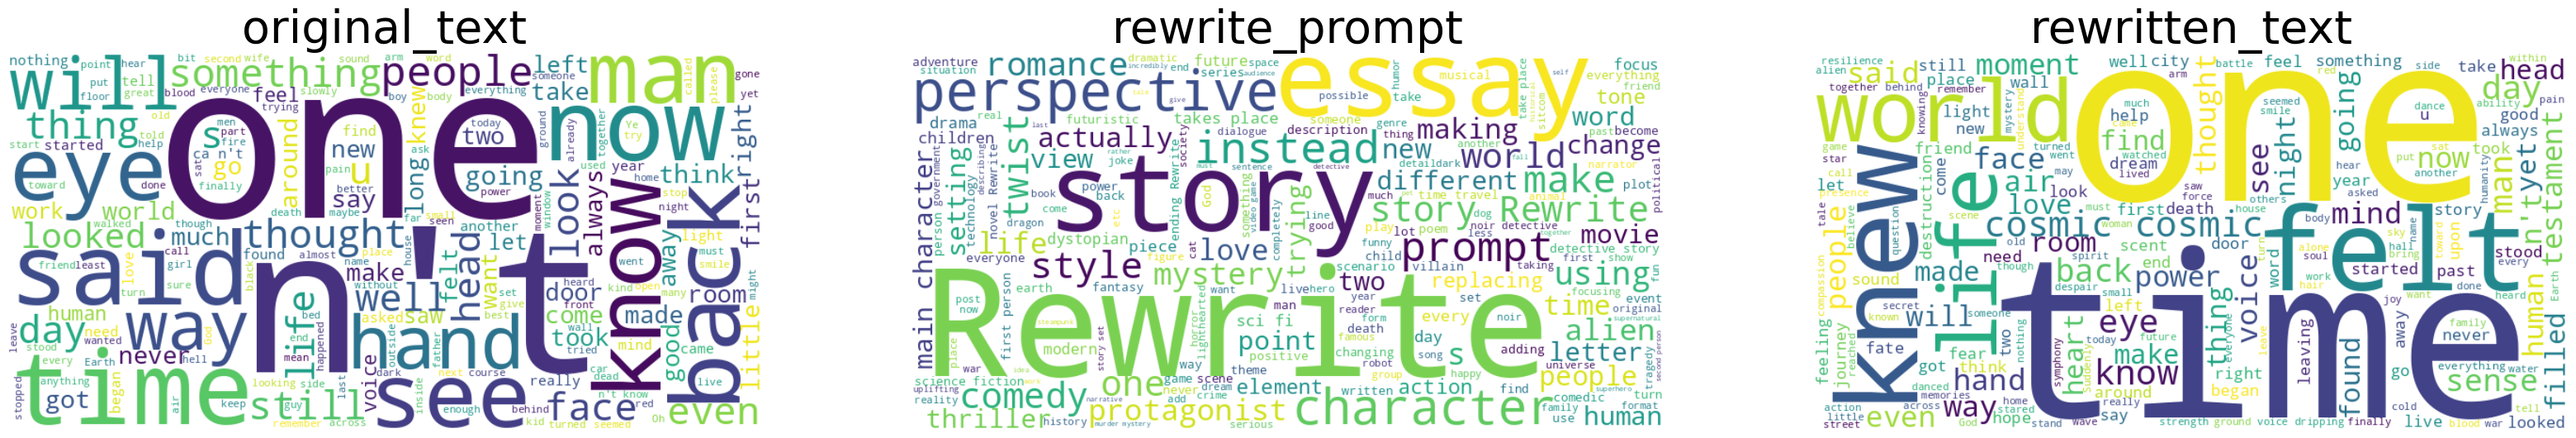

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(40, 20))
columns = ['original_text', 'rewrite_prompt', 'rewritten_text']
for i, column in enumerate(columns):
    wordcloud = generate_wordcloud(rewrite_nbroad, column)
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis("off")
    axs[i].set_title(column,fontsize=40)

plt.show()

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Calculate Text Similarity using cosine similarity
def calculate_similarity(text1, text2):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform([text1, text2])
    similarity_matrix = cosine_similarity(tfidf_matrix)
    return similarity_matrix[0][1]

# Calculate similarity for each pair of 'original_text' and 'rewritten_text'
similarity_scores_dataset1 = []
similarity_scores_dataset2 = []

for index, row in gali1eo.iterrows():
    similarity_scores_dataset1.append(calculate_similarity(row['original_text'], row['rewritten_text']))

for index, row in rewrite_nbroad.iterrows():
    similarity_scores_dataset2.append(calculate_similarity(row['original_text'], row['rewritten_text']))

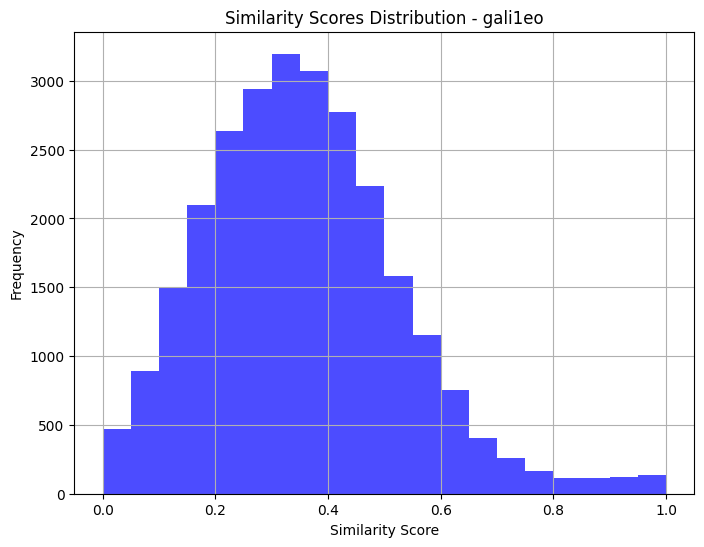

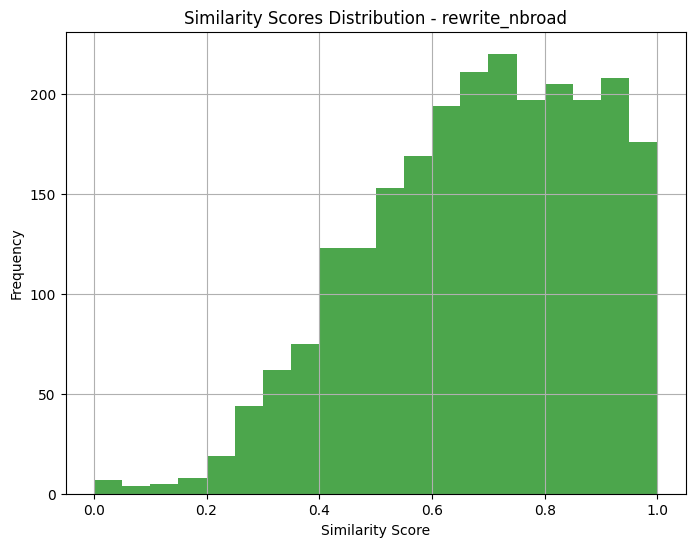

In [11]:
# Plot histogram of similarity scores for dataset 1
plt.figure(figsize=(8, 6))
plt.hist(similarity_scores_dataset1, bins=20, color='blue', alpha=0.7)
plt.title('Similarity Scores Distribution - gali1eo')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot histogram of similarity scores for dataset 2
plt.figure(figsize=(8, 6))
plt.hist(similarity_scores_dataset2, bins=20, color='green', alpha=0.7)
plt.title('Similarity Scores Distribution - rewrite_nbroad')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Creating just one dataset

In [12]:
all_prompts = pd.concat([gali1eo, rewrite_nbroad], axis=0)
all_prompts

id                                      original_text  \
0       35671182  Hayley Murdoch, 29, and Sheila Dixon, 71, both...   
1       35572796  The railway line was closed for a number of ho...   
2       14394831  Presented by Barney Harwood, this Newsround sp...   
3       36316854  They are a 317-unit development in the Athleti...   
4       40738583  VW said it was normal for manufacturers to exc...   
...          ...                                                ...   
2395  ljSaWTXjFc  `` Dave, have you seen this?'' There is no ans...   
2396  nwZeXhsofO  I posted something like this a while ago, I gu...   
2397  ozaryEVFvK  `` Oh Darling, it was absolutely dreadful!'' M...   
2398  WTvBtRNlQS  Ubwuwuaua! I exclaim shaking my head back and ...   
2399  jcLSWkFNKS  `` Yeah I'll hook you up fam, how many?'' \n \...   

                                         rewrite_prompt  \
0        Turn this into a responsibility to be assumed.   
1       Explain this as if it were a mentor's guidance.   
2     Transform it into a grand opera's dramatic fin...   
3      Transform it into a cooking recipe with a twist.   
4     Write the text as if it were a professional ph...   
...                                                 ...   
2395            Rewrite this as a Shakespearean tragedy   
2396  Rewrite the story as if you are a famous celeb...   
2397  Rewrite the story as an upbeat mystery story (...   
2398  Rewrite the story from the perspective of the ...   
2399  Rewrite this story to focus on the moral dilem...   

                                         rewritten_text  
0     Sure, here is the responsibility to be assumed...  
1     Here is the explanation with a mentor's guidan...  
2     ## The Final Curtain Rises\n\n**Scene:** The e...  
3     **Recipe for Spicy Chicken Wings with a Caribb...  
4     **Photo Shoot Plan - Volkswagen Cartel Allegat...  
...                                                 ...  
2395  Alas, poor Dave, a victim of fate's cruel hand...  
2396  I'm the epitome of stardom, yet I can't shake ...  
2397  Hey folks, buckle up for a mystery that will h...  
2398  Ubwuwuaua. The whispers of the wind dance thro...  
2399  The aroma of fresh pizza filled the air, but t...  

[29020 rows x 4 columns]

In [13]:
rew = pd.read_csv('/kaggle/input/llm-recovery-pair/rewrite_prompts3.csv')
rew

Unnamed: 0                                    rewrite_prompts
0              0                  Transform this into a fairy tale.
1              1         Write it as a hard-boiled detective story.
2              2         Convert it into a Shakespearean soliloquy.
3              3        Rewrite this as a modern-day sitcom script.
4              4              Turn it into a classic Greek tragedy.
...          ...                                                ...
1466         966        Convert this into a filmmaker's storyboard.
1467         967  Present this as a chair's TED Talk on ergonomi...
1468         968  Write the text as if it were a craft beer fest...
1469         969  Explain this as if it were a realization to be...
1470         970          Rewrite this as a pact to be agreed upon.

[1471 rows x 2 columns]

# Filter out those texts that give away the prompt
We remove here all the *rewritten_text* that begin with:
- *Here is the*
- *Sure*
- *The text*

This leaves us with a lot less rows in our dataset

In [14]:
# Split the text into words based on whitespace and return the length of the resulting list
def word_count(text):
    return len(str(text).split())

# Define the columns for which you want to calculate the average word count
columns = ['original_text', 'rewritten_text', 'rewrite_prompt']

# Iterate over the columns and calculate the average word count for each
for column in columns:
    word_counts = all_prompts[column].apply(word_count)
    average_word_count = np.mean(word_counts)
    print(f"Average Word Count for {column}: {average_word_count}")

Average Word Count for original_text: 156.6158511371468
Average Word Count for rewritten_text: 157.42398345968297
Average Word Count for rewrite_prompt: 9.731736733287388


In [15]:
all_prompts = all_prompts.loc[~all_prompts['rewritten_text'].str.startswith(("Here is the", "Sure,", "The text"))]

all_prompts = all_prompts[
    (all_prompts['original_text'].apply(word_count) <= 200) &
    (all_prompts['rewritten_text'].apply(word_count) <= 200) &
    (all_prompts['rewrite_prompt'].apply(word_count) <= 10)
]
all_prompts

id                                      original_text  \
2       14394831  Presented by Barney Harwood, this Newsround sp...   
3       36316854  They are a 317-unit development in the Athleti...   
5       34619280  Every single Bramley apple ever eaten can be t...   
6       29706253  Media playback is unsupported on your device\n...   
7       40263797  The award is chosen by a race management team,...   
...          ...                                                ...   
2249  nsvXKTAbfL  *Sasha. I watched you grow up. I taught you ho...   
2279  hKjzSPTPJX  His lungs gave after there was no more air, hi...   
2337  jhRcvOQuPp  Entry No. 56-Day 124 \n It's been a week since...   
2341  STGmafhogp  Mr. Nothing held his thumb over the red button...   
2344  DakvfzZYcw  You think I'm a compulsive liar? Do you even k...   

                                         rewrite_prompt  \
2     Transform it into a grand opera's dramatic fin...   
3      Transform it into a cooking recipe with a twist.   
5          Recast it as a luxury product advertisement.   
6          Imagine this as a Beatles-themed video game.   
7               Present this as a chef's secret recipe.   
...                                                 ...   
2249    Rewrite the essay as a "feel good" movie script   
2279               Rewrite the essay to only use verbs.   
2337  Rewrite the essay with more action and less di...   
2341     Rewrite the prompt as a noir detective story .   
2344  Rewrite it in the style of a Shakespearian sol...   

                                         rewritten_text  
2     ## The Final Curtain Rises\n\n**Scene:** The e...  
3     **Recipe for Spicy Chicken Wings with a Caribb...  
5     ## Bramley Apple Feast: Elevate Your Senses Wi...  
6     ## The Day the Force Awakens - A Beatles-Theme...  
7     ## Chef's Secret Recipe: Norton's TT Triumph\n...  
...                                                 ...  
2249  **FADE IN:**\n\n**INT. HOSPITAL ROOM - DAY**\n...  
2279  Lungs exhaled their last, fists clenched, bloo...  
2337  Entry No. 56-Day 124\n\nIt has been a week sin...  
2341  The grizzled detective, Mr. Nothing, stood at ...  
2344  O weary soul, do you question my veracity? Do ...  

[11693 rows x 4 columns]

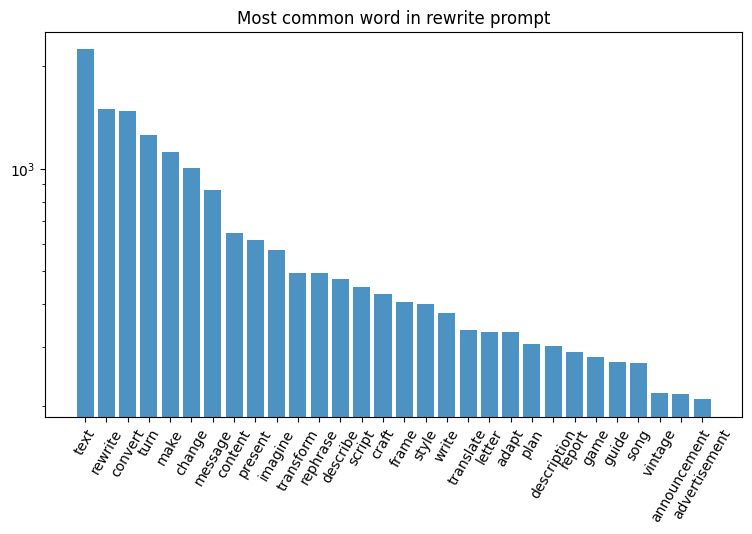

In [16]:
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords

# Get the most common word in the rewrite prompts
stop_words = set(stopwords.words('english'))
most_common = all_prompts["rewrite_prompt"].apply(
    lambda x: [w.lower() for w in re.sub(r"[^\w\s]","", x).rsplit(" ") if not w.lower() in stop_words]
)

most_common = most_common.explode().value_counts()[:30]

plt.figure(figsize=(9, 5))
plt.bar(most_common.index, most_common.values, alpha=0.8, log=True)
plt.title("Most common word in rewrite prompt")
plt.xticks(rotation=60)
plt.show()

# Prompt Analysis

In [17]:
small_sample = all_prompts.sample(100).reset_index(drop=True)

In [18]:
from sentence_transformers import SentenceTransformer

# Load the T5-based Sentence Transformer model
model_name = 'sentence-transformers/sentence-t5-base'
model = SentenceTransformer(model_name)

2024-08-27 23:21:48.128025: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 23:21:48.128133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 23:21:48.266087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/219M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [19]:
from sklearn.manifold import TSNE

# Define a function to encode text into embeddings
def encode_text(text):
    # Encode the text using the loaded model
    embedding = model.encode(text, convert_to_tensor=True)
    return embedding

# Encode rewrite prompts into embeddings
prompt_embeddings = []

for prompt in small_sample['rewrite_prompt']:
    prompt_embedding = encode_text(prompt)
    prompt_embeddings.append(prompt_embedding.cpu())  # Move tensor to CPU

# Stack embeddings tensors
prompt_embeddings = torch.stack(prompt_embeddings).cpu()  # Move tensor to CPU

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(prompt_embeddings.cpu())  # Move tensor to CPU

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

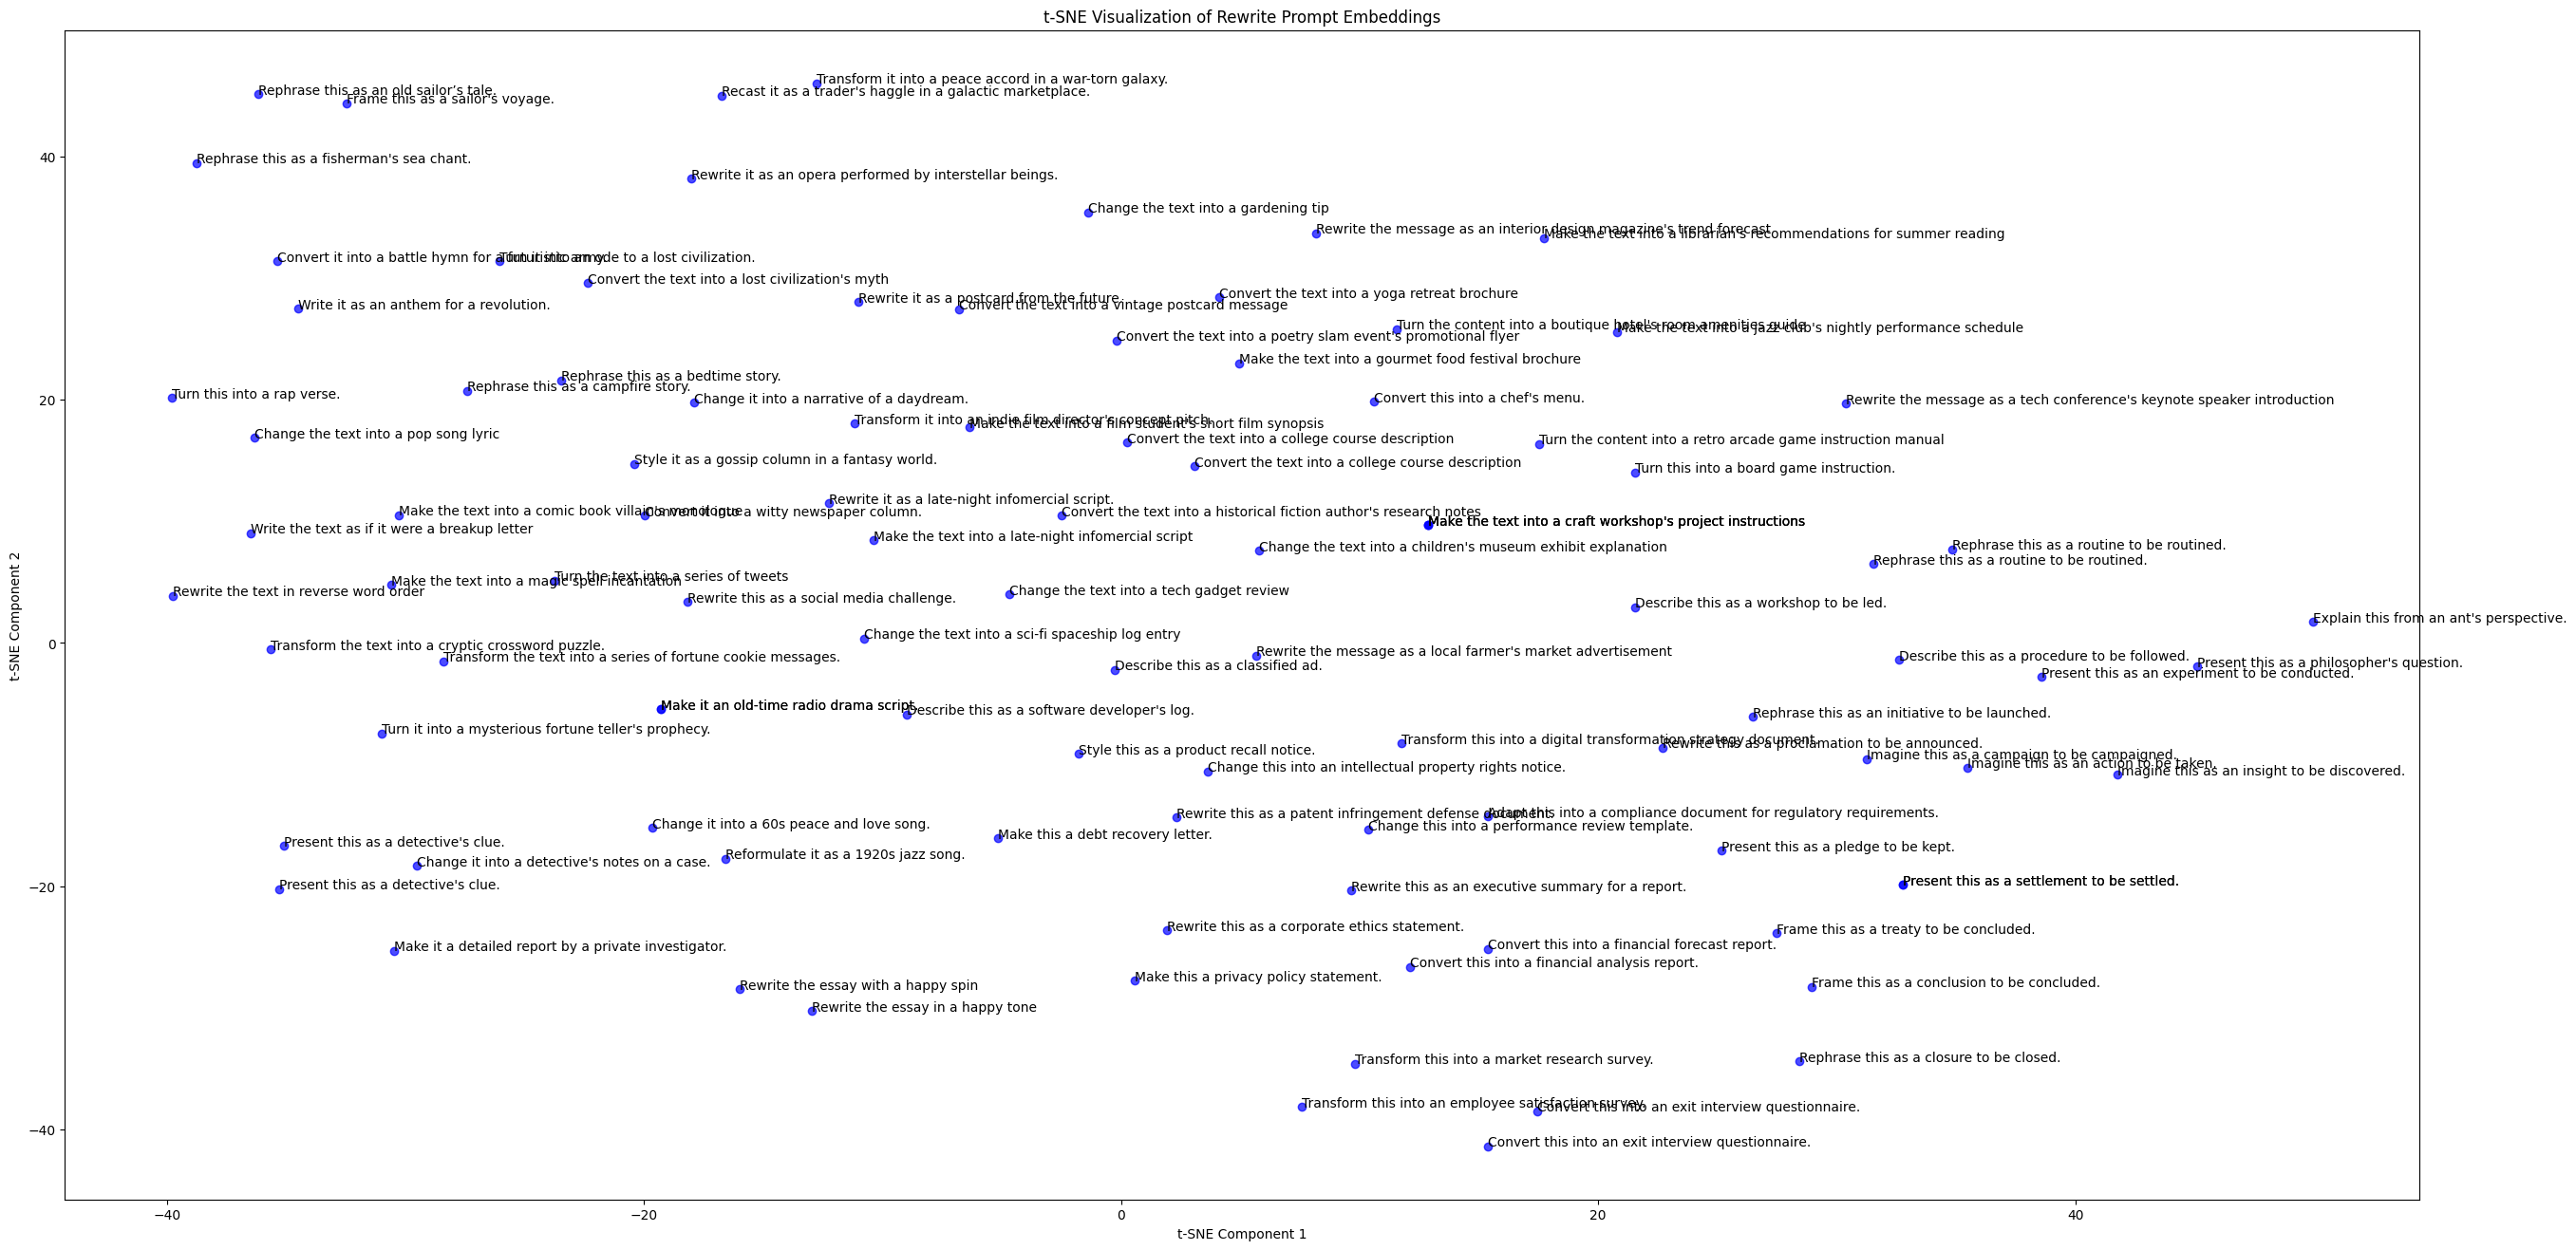

In [20]:
# Plot the reduced-dimensional embeddings
plt.figure(figsize=(32, 16))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='blue', alpha=0.7)
plt.title('t-SNE Visualization of Rewrite Prompt Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Annotate each point with its index
for i, txt in enumerate(small_sample['rewrite_prompt']):
    plt.annotate(txt, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.savefig('prompt_embeddings_plot.png', dpi=300)  # Specify the filename and DPI
plt.show()

In [21]:
from sklearn.decomposition import PCA

# Encode rewrite prompts into embeddings
prompt_embeddings = []

for prompt in small_sample['rewrite_prompt']:
    prompt_embedding = encode_text(prompt)
    prompt_embeddings.append(prompt_embedding.cpu())  # Move tensor to CPU

# Stack embeddings tensors
prompt_embeddings = torch.stack(prompt_embeddings).cpu()  # Move tensor to CPU

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(prompt_embeddings.cpu())  # Move tensor to CPU

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

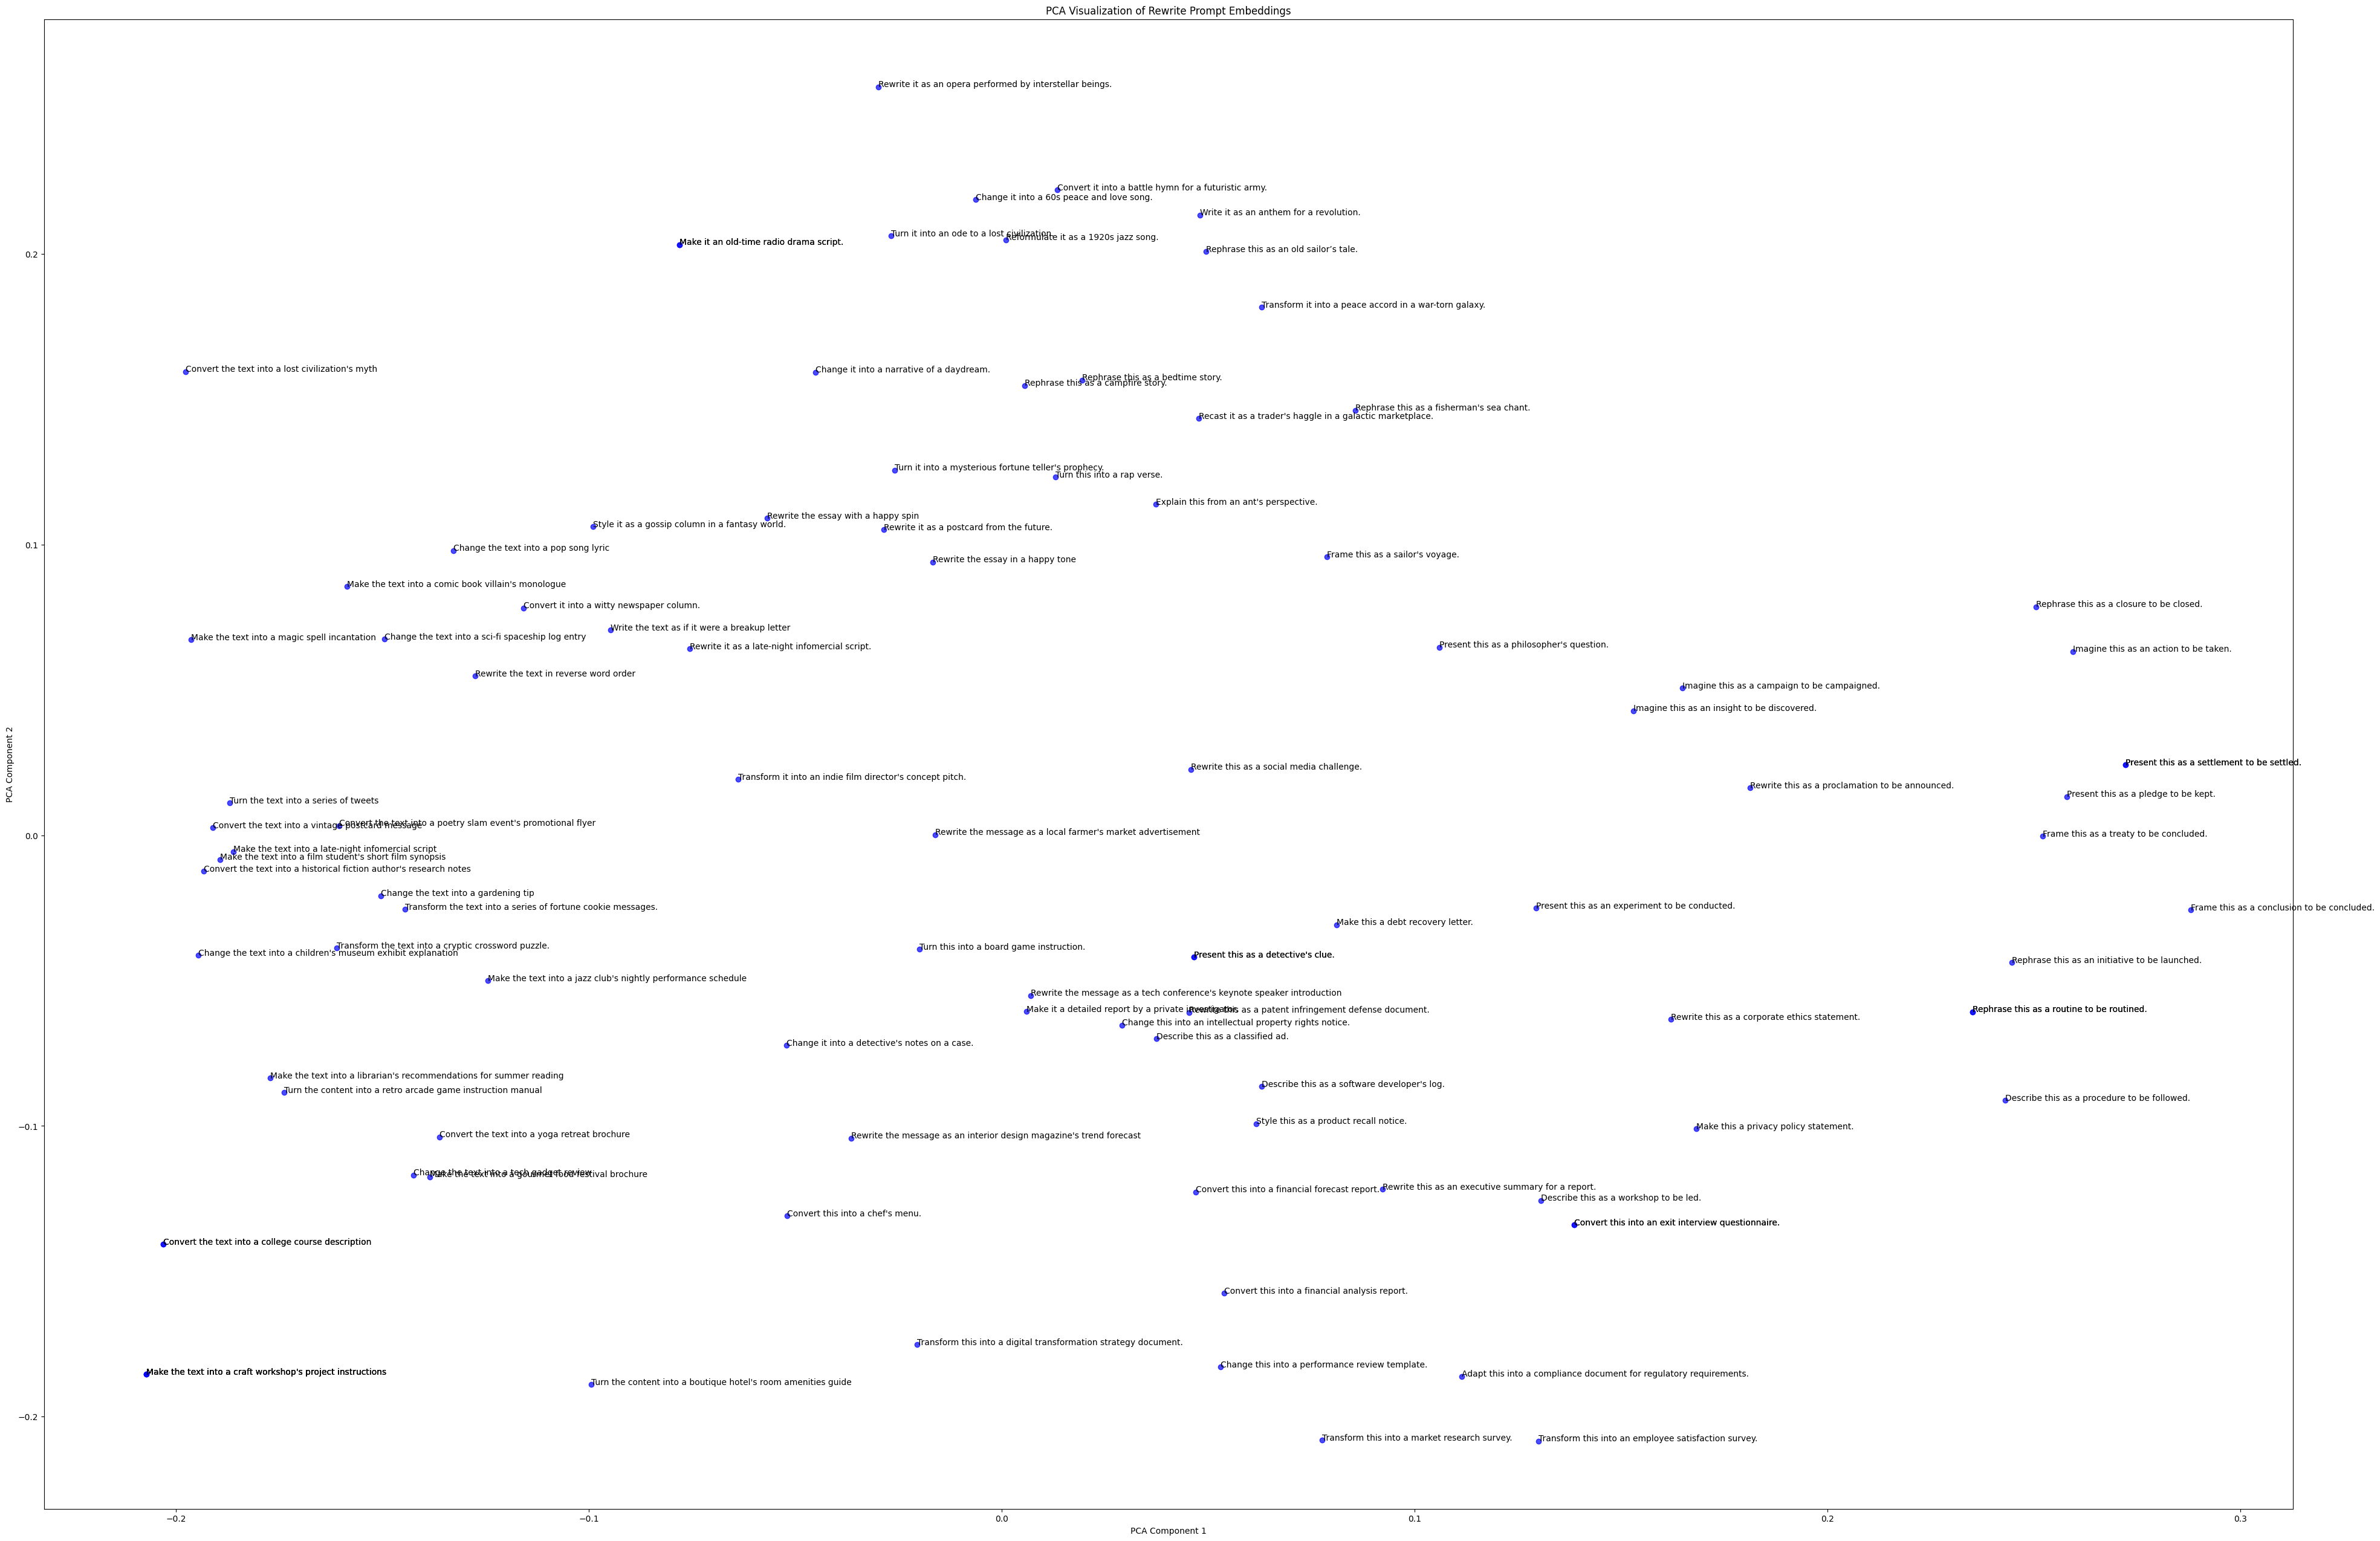

In [22]:
# Plot the reduced-dimensional embeddings
plt.figure(figsize=(48, 32))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='blue', alpha=0.7)
plt.title('PCA Visualization of Rewrite Prompt Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Annotate each point with its index
for i, txt in enumerate(small_sample['rewrite_prompt']):
    plt.annotate(txt, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.savefig('prompt_embeddings_pca_plot.png', dpi=300)
plt.show()

# Define the tokenizer
We are gonna use the [chat template from HF](https://huggingface.co/docs/transformers/main/en/chat_templating) and this changes based on the model that we use.

In [23]:
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2", trust_remote_code=True)
tokenizer.padding_side = 'right'
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True
tokenizer.add_bos_token, tokenizer.add_eos_token

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

(True, True)

# Split into Train and Test

In [24]:
from sklearn.model_selection import train_test_split

# Shuffle the DataFrame
df_shuffled = all_prompts.sample(frac=1, random_state=42)  # random_state for reproducibility

# Determine the size of your train set, for example, 80% for train and 20% for test
train_size = int(0.8 * len(df_shuffled))

# Split the shuffled DataFrame into train and test DataFrames
train_df = df_shuffled[:train_size]
test_df = df_shuffled[train_size:]

# You can reset index if you want
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [25]:
train_df.head()

id                                      original_text  \
0  35800193  The 34-year-old needed 50 minutes to take the ...   
1  37792768  Cruz, 35, will become the first openly gay box...   
2  38002421  The tennis coach is one of three honorary grad...   
3  34668261  A 47-year-old woman, who was one of the injure...   
4  38729631  Djodjo Nsaka, 19 from Streatham, was attacked ...   

                                      rewrite_prompt  \
0              Convert this into a coach's pep talk.   
1           Turn this into an astronaut's log entry.   
2                     Present this as a news report.   
3         Change the text into a radio jingle lyrics   
4  Make it a detailed report by a private investi...   

                                      rewritten_text  
0  "Listen up, team. We're in the heat of battle,...  
1  **Log Entry - 02/26/2023**\n\nI am currently o...  
2  **News Report:**\n\n**Dundee, UK -** Former te...  
3  (Verse 1)\nRhos-on-Sea, Marine Drive,\nA wreck...  
4  **Private Investigator's Report**\n\n**Date:**...

In [26]:
test_df.head()

id                                      original_text  \
0  40837062  South Wales Police officers had been pursuing ...   
1  36917156  Police were told an Audi's number plates were ...   
2  38155860  Mr Burke, 19, from Ripon in North Yorkshire, w...   
3  35189843  Twenty-four-year-old Aldis Minakovskis is alle...   
4  36670719  The 29-year-old has signed a four-year contrac...   

                                      rewrite_prompt  \
0  Make the text into a gourmet food festival bro...   
1        Describe this as an expertise to be gained.   
2               Change the text into an art critique   
3    Make the text into a detective's case file note   
4     Convert this into a financial forecast report.   

                                      rewritten_text  
0  ## Gourmet Food Festival Brochure\n\n**Indulge...  
1  The expertise gained in this scenario is the a...  
2  **Art Critique**\n\nThe text provided does not...  
3  ## Detective's Case File Note - Aldis Minakovs...  
4  **Financial Forecast Report**\n\n**Company:** ...

In [27]:
train_df.to_csv('llm-prompt-recovery-train.csv')

# Prompt configuration

In [28]:
#original text prefix
orig_prefix = "I need you to tell me what single-sentence prompt transformed 'ORIGINAL TEXT' into 'RE-WRITTEN TEXT.' ORIGINAL TEXT:"

#modified text prefix
rewrite_prefix = "RE-WRITTEN TEXT:"

#provided as start of Mistral response (anything after this is used as the prompt)
response_start = "The single-sentence prompt was:"

def get_train_prompt(orig_text, transformed_text, prompt):

    messages = [
        #actual prompt
        {"role": "user", "content": f"{orig_prefix} {orig_text} {rewrite_prefix} {transformed_text}"},
        {"role": "assistant", "content": f"{response_start} {prompt}"},
    ]

    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

# Create the training prompt sequences

In [29]:
pd.set_option('display.max_colwidth', 150)

train_texts = []

for index, row in all_prompts.iterrows():
    result = get_train_prompt(row["original_text"], 
                              row["rewritten_text"], 
                              row["rewrite_prompt"])
    train_texts.append(result)

train_df = pd.DataFrame(train_texts, columns=['text'])
train_df

text
0      <s> [INST] I need you to tell me what single-sentence prompt transformed 'ORIGINAL TEXT' into 'RE-WRITTEN TEXT.' ORIGINAL TEXT: Presented by Barne...
1      <s> [INST] I need you to tell me what single-sentence prompt transformed 'ORIGINAL TEXT' into 'RE-WRITTEN TEXT.' ORIGINAL TEXT: They are a 317-uni...
2      <s> [INST] I need you to tell me what single-sentence prompt transformed 'ORIGINAL TEXT' into 'RE-WRITTEN TEXT.' ORIGINAL TEXT: Every single Braml...
3      <s> [INST] I need you to tell me what single-sentence prompt transformed 'ORIGINAL TEXT' into 'RE-WRITTEN TEXT.' ORIGINAL TEXT: Media playback is ...
4      <s> [INST] I need you to tell me what single-sentence prompt transformed 'ORIGINAL TEXT' into 'RE-WRITTEN TEXT.' ORIGINAL TEXT: The award is chose...
...                                                                                                                                                      ...
11688  <s> [INST] I need you to tell me what single-sentence prompt transformed 'ORIGINAL TEXT' into 'RE-WRITTEN TEXT.' ORIGINAL TEXT: *Sasha. I watched ...
11689  <s> [INST] I need you to tell me what single-sentence prompt transformed 'ORIGINAL TEXT' into 'RE-WRITTEN TEXT.' ORIGINAL TEXT: His lungs gave aft...
11690  <s> [INST] I need you to tell me what single-sentence prompt transformed 'ORIGINAL TEXT' into 'RE-WRITTEN TEXT.' ORIGINAL TEXT: Entry No. 56-Day 1...
11691  <s> [INST] I need you to tell me what single-sentence prompt transformed 'ORIGINAL TEXT' into 'RE-WRITTEN TEXT.' ORIGINAL TEXT: Mr. Nothing held h...
11692  <s> [INST] I need you to tell me what single-sentence prompt transformed 'ORIGINAL TEXT' into 'RE-WRITTEN TEXT.' ORIGINAL TEXT: You think I'm a co...

[11693 rows x 1 columns]

In [30]:
#(2 is nice example)
print(train_df.iloc[0]["text"])

<s> [INST] I need you to tell me what single-sentence prompt transformed 'ORIGINAL TEXT' into 'RE-WRITTEN TEXT.' ORIGINAL TEXT: Presented by Barney Harwood, this Newsround special explores the issue of bereavement and the effect it has on children's lives.
It tells the story of four children, all of whom have lost someone they love. RE-WRITTEN TEXT: ## The Final Curtain Rises

**Scene:** The echoes of a bell chime fade into a somber melody as the stage lights dim. 

**Characters:**

* **Maria (12):** Bereaved by the loss of her father.
* **Ben (13):** The cousin of Maria who offers comfort and presence.
* **Maya (14):** A coping artist who creates vivid imagery through drawings.
* **Sam (15):** A withdrawn loner who finds solace in music.

**A tapestry of emotions unfolds:**

Maria, her face etched with grief, sits wrapped in a shroud of sadness. Ben, his heart filled with empathy, attempts to bring her solace, but her pain remains insurmountable. Maya, her artistic prowess mirroring h

In [31]:
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)